### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import (AveragePooling2D, Dropout, Flatten, Dense, Input,
                                   Reshape, multiply, add, GlobalAveragePooling2D, Conv2D)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, Activation, ZeroPadding2D
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, DepthwiseConv2D, BatchNormalization,
                                     ReLU, GlobalAveragePooling2D, Reshape, Dense, multiply, Add)
from tensorflow.keras.models import Model


### **Define Paths & Load Data**

In [ ]:
# NIH Dataset paths
BASE_PATH = "/content/drive/MyDrive/NIH_processed"
TRAIN_PATH = "/content/drive/MyDrive/NIH_processed/train"
TEST_PATH = "/content/drive/MyDrive/NIH_processed/test"

labels = ['pneumonia', 'normal']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath      label
0  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
1  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
2  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
3  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia
4  /content/drive/MyDrive/NIH_processed/train/pne...  pneumonia

The shape of The Train data is: (5320, 2)
The shape of The Test data is: (1784, 2)


In [ ]:
# Check class imbalance
def check_class_imbalance(directory):
    """Check class distribution in the dataset"""
    print(f"Checking class distribution in: {directory}")
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  {class_name}: {count} images")
    print()

print("NIH Dataset Class Distribution:")
check_class_imbalance(TRAIN_PATH)
check_class_imbalance(TEST_PATH)

NIH Dataset Class Distribution:
Checking class distribution in: /content/drive/MyDrive/NIH_processed/train
  normal: 4069 images
  pneumonia: 1251 images

Checking class distribution in: /content/drive/MyDrive/NIH_processed/test
  normal: 1272 images
  pneumonia: 512 images



In [ ]:
# Create datasets
IMAGE_SIZE = (224, 224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names


class_labels =['pneumonia', 'normal']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))


Training Images:
Found 5320 files belonging to 2 classes.
Using 4256 files for training.

Validation Images:
Found 5320 files belonging to 2 classes.
Using 1064 files for validation.

Testing Images:
Found 1784 files belonging to 2 classes.


In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "normal")) if f.endswith(('png', 'jpg', 'jpeg'))] +
               [f for f in os.listdir(os.path.join(path, "pneumonia")) if f.endswith(('png', 'jpg', 'jpeg'))])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "normal", f) for f in os.listdir(os.path.join(TRAIN_PATH, "normal"))] + \
                [os.path.join(TRAIN_PATH, "pneumonia", f) for f in os.listdir(os.path.join(TRAIN_PATH, "pneumonia"))]

trainLabels = [0 if "normal" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Data generators
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 30

trainAug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 5320 images belonging to 2 classes.
Found 5320 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


#### **Build Model**

In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "normal")) if f.endswith('.jpeg')] +
               [f for f in os.listdir(os.path.join(path, "pneumonia")) if f.endswith('.jpeg')])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)


# Enhanced Squeeze and Excitation block with improved architecture
def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal',
               use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(se)
    se = Dropout(0.2)(se)  # Added dropout for regularization
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Enhanced EfficientNetB3-based model with SE integration
def enhanced_efficientnet_model(input_shape=(224, 224, 3), include_top=True, weights='imagenet', classes=2, ratio=16):
    base_model = EfficientNetB3(input_shape=input_shape, include_top=False, weights=weights)

    x = base_model.output

    # Add SE block after base model
    x = squeeze_excite_block(x, ratio=ratio)

    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = BatchNormalization()(x)  # Added batch normalization
        x = Dropout(0.3)(x)
        x = Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(classes, activation='softmax', use_bias=True)(x)

    model = Model(inputs=base_model.input, outputs=x)

    # Unfreeze top layers for fine-tuning
    for layer in base_model.layers[:-20]:  # Freeze bottom layers
        layer.trainable = False

    for layer in base_model.layers[-20:]:  # Unfreeze top 20 layers
        layer.trainable = True

    return model

#### **Compile Model**

In [ ]:
# Model architecture with enhanced backbone
CLASSES = ["normal","pneumonia"]
model = enhanced_efficientnet_model(input_shape=(224, 224, 3), include_top=True,
                                   weights='imagenet', classes=len(CLASSES), ratio=16)

# Custom focal loss for imbalanced data
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        alpha_t = y_true * alpha + (tf.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.ones_like(y_true) - y_true) * (tf.ones_like(y_true) - y_pred)
        focal_loss = - alpha_t * tf.pow((tf.ones_like(y_true) - p_t), gamma) * tf.math.log(p_t)

        return tf.reduce_mean(focal_loss)
    return focal_loss_fixed

# Compile model with enhanced optimizer and loss
print("Compiling model")
opt = AdamW(learning_rate=INIT_LR, weight_decay=1e-4)
model.compile(loss=focal_loss(alpha=0.25, gamma=2.0), optimizer=opt,
              metrics=["accuracy", "precision", "recall"])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,479,601 (43.79 MB)

 Trainable params: 4,065,634 (15.51 MB)

 Non-trainable params: 7,413,967 (28.28 MB)

#### **Train Model**

In [ ]:
# Enhanced callbacks for better training control
os.makedirs("/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3",
                          "enhanced_efficientnet_weights-{epoch:03d}-{val_loss:.4f}.keras"])

checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if no improvement for 3 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

# Train model with enhanced configuration
print("Model Fitting")
start_time = time.time()

history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=totalTrain // (5 * BATCH_SIZE),
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Model Fitting
Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5457 - loss: 0.6707 - precision: 0.5457 - recall: 0.5457
Epoch 1: val_loss improved from inf to 0.31255, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3/enhanced_efficientnet_weights-001-0.3126.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1574s 9s/step - accuracy: 0.5458 - loss: 0.6703 - precision: 0.5458 - recall: 0.5458 - val_accuracy: 0.0407 - val_loss: 0.3126 - val_precision: 0.0407 - val_recall: 0.0407 - learning_rate: 1.0000e-04
Epoch 2/30
  1/166 ━━━━━━━━━━━━━━━━━━━━ 15:15 6s/step - accuracy: 0.5938 - loss: 0.4188 - precision: 0.5938 - recall: 0.5938

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.31255
166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5938 - loss: 0.4188 - precision: 0.5938 - recall: 0.5938 - val_accuracy: 0.0398 - val_loss: 0.3152 - val_precision: 0.0398 - val_recall: 0.0398 - learning_rate: 1.0000e-04
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5945 - loss: 0.5063 - precision: 0.5945 - recall: 0.5945
Epoch 3: val_loss improved from 0.31255 to 0.18632, saving model to /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3/enhanced_efficientnet_weights-003-0.1863.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 1194s 7s/step - accuracy: 0.5946 - loss: 0.5062 - precision: 0.5946 - recall: 0.5946 - val_accuracy: 0.5682 - val_loss: 0.1863 - val_precision: 0.5682 - val_recall: 0.5682 - learning_rate: 1.0000e-04
Epoch 4/30
  1/166 ━━━━━━━━━━━━━━━━━━━━ 14:07 5s/step - accuracy: 0.5938 - loss: 0.6752 - precision: 0.5938 - recall: 0.5938
Epoch 4: val_loss improved from 0.18632 to 0.18434, saving mode

### **Evaluation**


Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 482s 9s/step - accuracy: 0.8692 - loss: 0.1033 - precision: 0.8692 - recall: 0.8692
Test Accuracy: 73.77%
Test Loss: 0.1442
56/56 ━━━━━━━━━━━━━━━━━━━━ 309s 5s/step

Classification Report:
              precision    recall  f1-score   support

      normal     0.7709    0.8994    0.8302      1272
   pneumonia     0.5733    0.3359    0.4236       512

    accuracy                         0.7377      1784
   macro avg     0.6721    0.6177    0.6269      1784
weighted avg     0.7142    0.7377    0.7135      1784


Confusion Matrix:
[[1144  128]
 [ 340  172]]
Accuracy: 0.7377
Sensitivity: 0.3359
Specificity: 0.8994


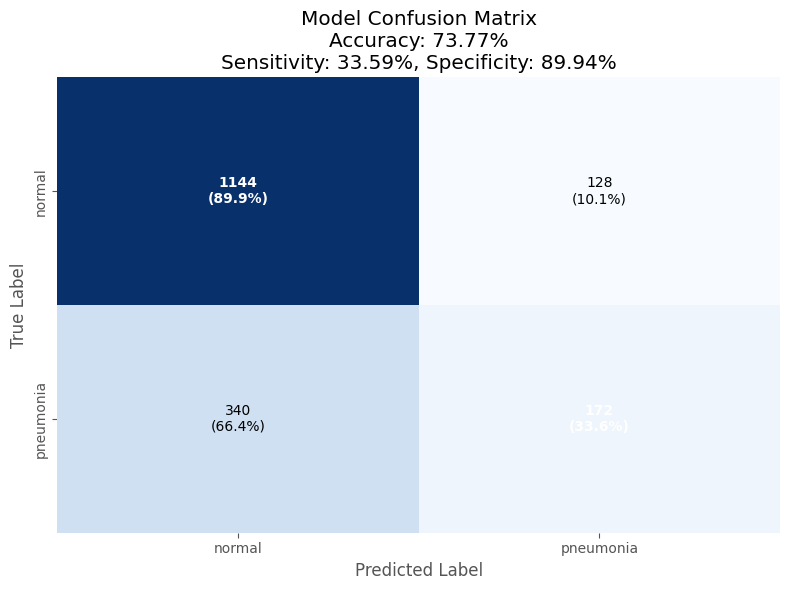

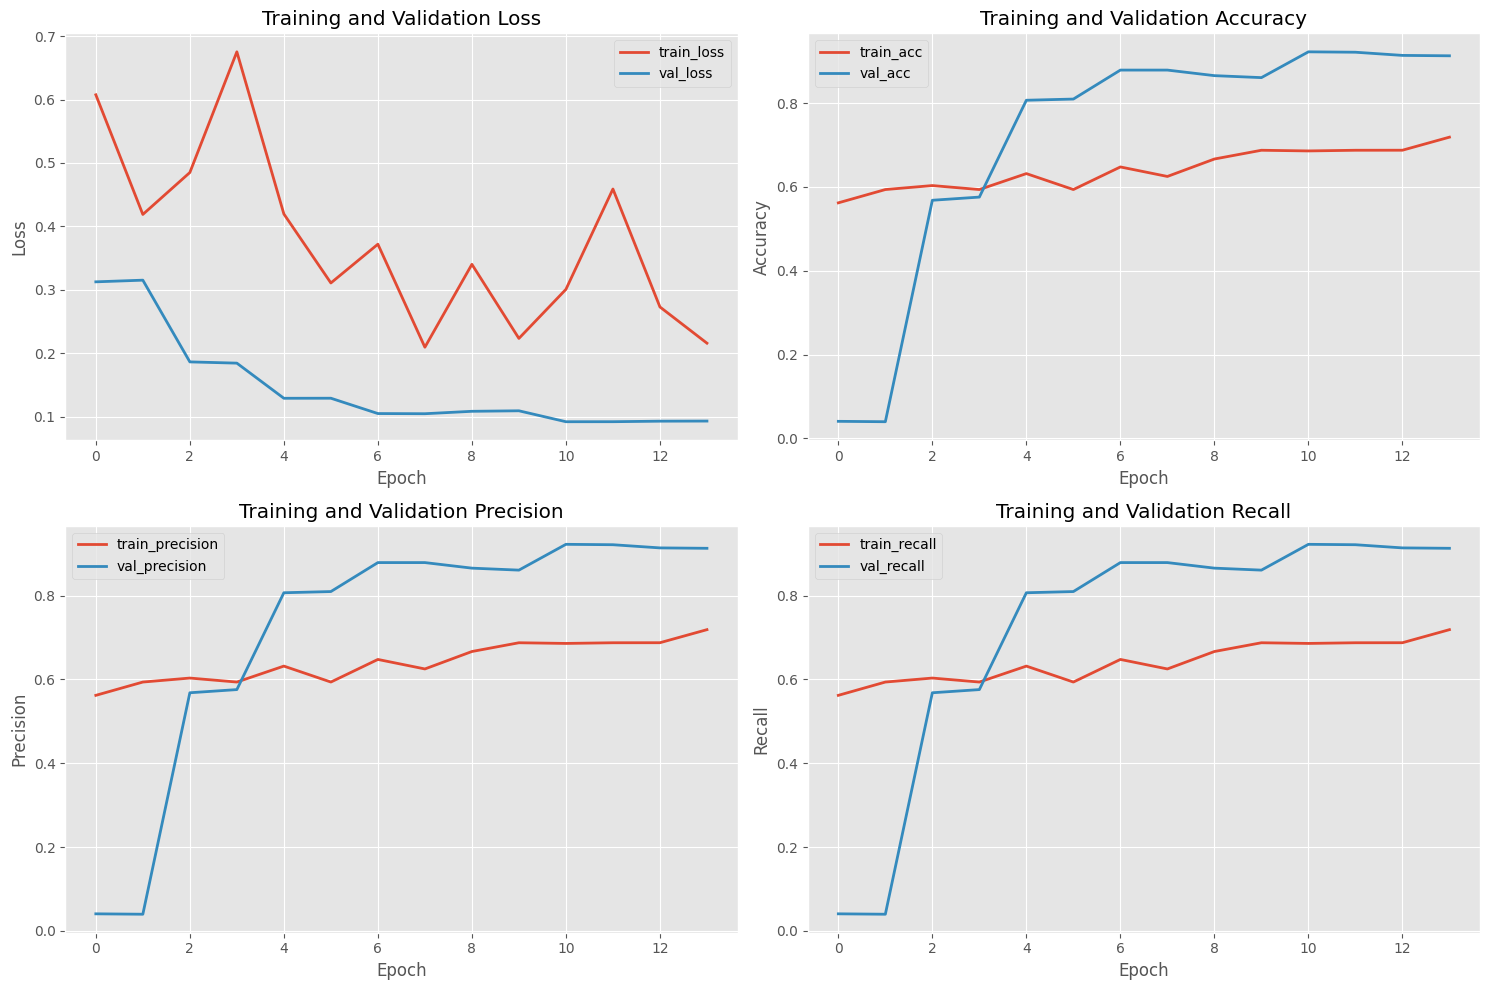

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        is_correct = (i == j)
        text = f"{cm[i, j]}\n({percentage:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='white' if is_correct else 'black',
               weight='bold' if is_correct else 'normal')

plt.title(f"Model Confusion Matrix\nAccuracy: {acc:.2%}\nSensitivity: {sensitivity:.2%}, Specificity: {specificity:.2%}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training history with enhanced metrics
plt.style.use("ggplot")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
ax1.plot(history.history["loss"], label="train_loss", linewidth=2)
ax1.plot(history.history["val_loss"], label="val_loss", linewidth=2)
ax1.set_title("Training and Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history.history["accuracy"], label="train_acc", linewidth=2)
ax2.plot(history.history["val_accuracy"], label="val_acc", linewidth=2)
ax2.set_title("Training and Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

# Precision plot
if 'precision' in history.history:
    ax3.plot(history.history["precision"], label="train_precision", linewidth=2)
    ax3.plot(history.history["val_precision"], label="val_precision", linewidth=2)
    ax3.set_title("Training and Validation Precision")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Precision")
    ax3.legend()
    ax3.grid(True)

# Recall plot
if 'recall' in history.history:
    ax4.plot(history.history["recall"], label="train_recall", linewidth=2)
    ax4.plot(history.history["val_recall"], label="val_recall", linewidth=2)
    ax4.set_title("Training and Validation Recall")
    ax4.set_xlabel("Epoch")
    ax4.set_ylabel("Recall")
    ax4.legend()
    ax4.grid(True)

plt.tight_layout()
plt.show()

#### **Evaluating Best Saved Model with Enhanced Visuals**

Loading the best model from: /content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3/enhanced_efficientnet_weights-011-0.0920.keras

Evaluating the best model...
56/56 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.8692 - loss: 0.1033 - precision: 0.8692 - recall: 0.8692
Test Accuracy (Best Model): 73.77%
Test Loss (Best Model): 0.1442
56/56 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step

Classification Report (Best Model):
              precision    recall  f1-score   support

      normal     0.7709    0.8994    0.8302      1272
   pneumonia     0.5733    0.3359    0.4236       512

    accuracy                         0.7377      1784
   macro avg     0.6721    0.6177    0.6269      1784
weighted avg     0.7142    0.7377    0.7135      1784


Confusion Matrix (Best Model):
[[1144  128]
 [ 340  172]]
Accuracy (Best Model): 0.7377
Sensitivity (Best Model): 0.3359
Specificity (Best Model): 0.8994


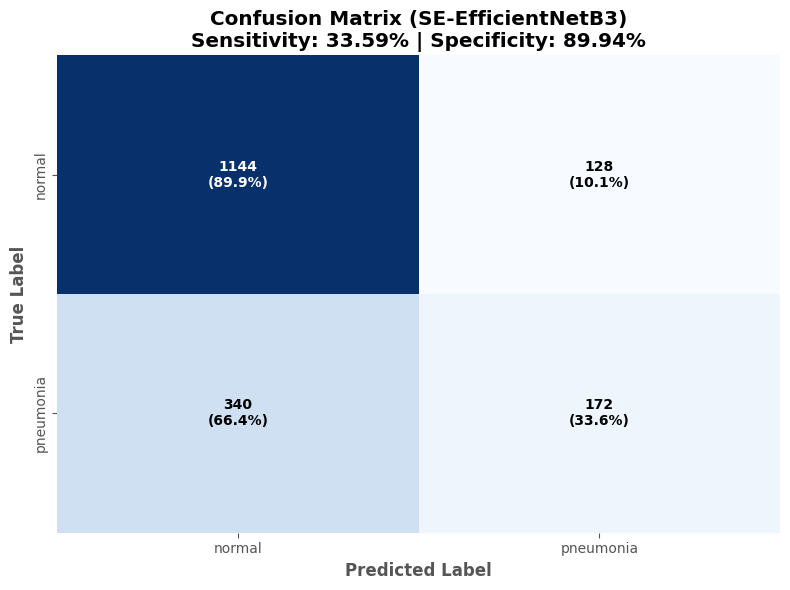


AUC Score (Best Model): 0.7399


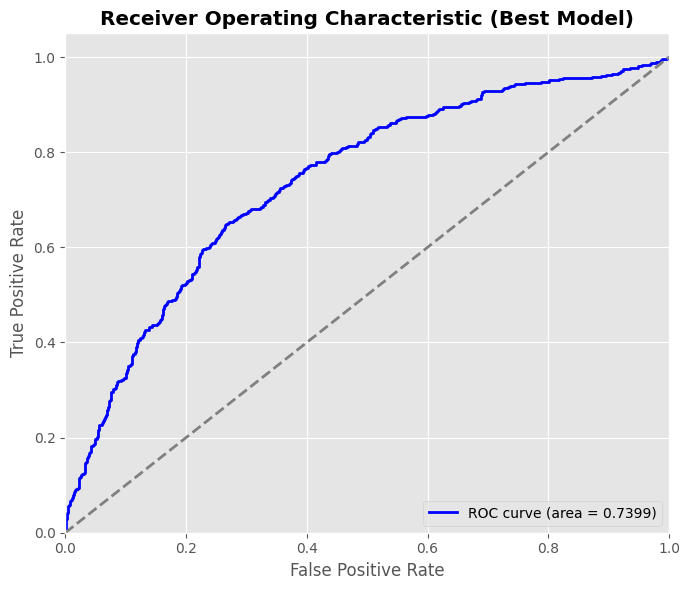

In [ ]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Find the best model checkpoint based on validation loss
list_of_files = glob.glob('/content/drive/MyDrive/NIH_processed/New_NIH_Models/SE-EfficientNetB3/enhanced_efficientnet_weights-*.keras')
if not list_of_files:
    print("No model checkpoints found.")
else:
    # Extract validation loss from filenames and find the best model
    best_loss = float('inf')
    best_model_path = None
    for file_path in list_of_files:
        match = re.search(r'-(\d+\.\d+)\.keras$', file_path)
        if match:
            loss = float(match.group(1))
            if loss < best_loss:
                best_loss = loss
                best_model_path = file_path

    if best_model_path:
        print(f"Loading the best model from: {best_model_path}")

        # Load the best model
        best_model = load_model(best_model_path, custom_objects={'focal_loss_fixed': focal_loss(alpha=0.25, gamma=2.0)})

        # Evaluate the best model
        print("\nEvaluating the best model...")
        test_results_best = best_model.evaluate(testGen, batch_size=BATCH_SIZE)
        print("Test Accuracy (Best Model): {:.2f}%".format(test_results_best[1] * 100))
        print("Test Loss (Best Model): {:.4f}".format(test_results_best[0]))

        # Predictions and classification report
        predIdxs_best = best_model.predict(testGen)
        predTest_best = np.argmax(predIdxs_best, axis=1)

        print("\nClassification Report (Best Model):")
        print(classification_report(testGen.classes, predTest_best, target_names=testGen.class_indices.keys(), digits=4))

        # Confusion matrix
        cm_best = confusion_matrix(testGen.classes, predTest_best)
        total_best = sum(sum(cm_best))
        acc_best = (cm_best[0, 0] + cm_best[1, 1]) / total_best
        sensitivity_best = cm_best[1, 1] / (cm_best[1, 0] + cm_best[1, 1])
        specificity_best = cm_best[0, 0] / (cm_best[0, 0] + cm_best[0, 1])

        print("\nConfusion Matrix (Best Model):")
        print(cm_best)
        print("Accuracy (Best Model): {:.4f}".format(acc_best))
        print("Sensitivity (Best Model): {:.4f}".format(sensitivity_best))
        print("Specificity (Best Model): {:.4f}".format(specificity_best))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        ax_best = sns.heatmap(cm_best, annot=False, fmt='d', cmap='Blues',
                              xticklabels=testGen.class_indices.keys(),
                              yticklabels=testGen.class_indices.keys(),
                              cbar=False)

        for i in range(cm_best.shape[0]):
            row_sum = cm_best[i, :].sum()
            for j in range(cm_best.shape[1]):
                percentage = (cm_best[i, j] / row_sum) * 100 if row_sum > 0 else 0
                text = f"{cm_best[i, j]}\n({percentage:.1f}%)"
                color = 'white' if (i == 0 and j == 0) else 'black'
                ax_best.text(j + 0.5, i + 0.5, text,
                             ha='center', va='center',
                             color=color,
                             fontweight='bold')

        plt.title(f"Confusion Matrix (SE-EfficientNetB3)\nSensitivity: {sensitivity_best:.2%} | Specificity: {specificity_best:.2%}",
                  fontweight='bold')
        plt.xlabel("Predicted Label", fontweight='bold')
        plt.ylabel("True Label", fontweight='bold')
        plt.tight_layout()
        plt.show()

        # ROC and AUC
        auc_best = roc_auc_score(testGen.classes, predIdxs_best[:, 1])
        print("\nAUC Score (Best Model): {:.4f}".format(auc_best))

        fpr_best, tpr_best, _ = roc_curve(testGen.classes, predIdxs_best[:, 1])
        plt.figure(figsize=(7, 6))
        plt.plot(fpr_best, tpr_best, color='blue', lw=2, label='ROC curve (area = %0.4f)' % auc_best)
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (Best Model)', fontweight='bold')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        print("Could not find a suitable model checkpoint.")

#### **Model Size**

In [ ]:
# Display model size
model_size = os.path.getsize(best_model_path) / (1024 * 1024)
print(f"Model size: {model_size:.2f} MB")

Model size: 76.14 MB
